pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [ ] Fazer previsão por liga

# Imports e carregamentos

In [245]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(434237, 27)


In [246]:
# pd.set_option('display.max_rows', None)
# display(df05ht[(df05ht['homeTeam'] == 'Grêmio Novorizontino') & (df05ht['awayTeam'] == 'Vancouver Whitecaps FC')])

In [247]:
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-22,10:26,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
1,2020-01-22,11:06,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
2,2020-01-22,11:45,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
3,2020-01-22,12:25,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
4,2020-01-22,13:04,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434232,2020-10-14,43:27,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,9.0,8.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434233,2020-10-14,44:07,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434234,2020-10-14,44:46,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434235,2020-10-14,45+0:26,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,11.0,10.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales


In [248]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-11-20 00:00:00


In [249]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

# Preprocessamento dos dados

## Limpeza

In [250]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)
# df.drop(columns=['minute_converted']).drop_duplicates().to_csv('data_teste.csv', index=False, encoding='utf-8')

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (434237, 27)
Valores únicos de minutos antes da conversão: ['10:26' '11:06' '11:45' ... '41:07' '22:60' '17:38'] 

Registros duplicados: 0
Registros nulos: 0

Jogos que serão retirados: 0

Dimensão do DataFrame após remoção: (434237, 27)
Total de registros retirados: 0


In [251]:
# datas com minutos inválidos
datas = df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()
for data in datas:
    print(f"'{data}',", end=' ')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

## Engenharia de recursos

In [256]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

# Eficiência defensiva: razão entre desarmes e chutes ao gol do adversário
df['defensive_efficiency'] = df['tackles_home'] / (df['shotsOngoal_away'] + 1)  # +1 para evitar divisão por zero

# Agressividade ao longo do tempo: combinando faltas e cartões amarelos com minutos
df['aggressiveness_over_time_home'] = (df['fouls_c_home'] + df['yellowcards_home']) * df['minute']
df['aggressiveness_over_time_away'] = (df['fouls_c_away'] + df['yellowcards_away']) * df['minute']

# Eficiência de posse de bola: razão entre tempo de posse e chutes ao gol
df['possession_efficiency_home'] = df['possessiontime_home'] / (df['shotsOngoal_home'] + 1)
df['possession_efficiency_away'] = df['possessiontime_away'] / (df['shotsOngoal_away'] + 1)

# Total de cartões por jogo
df['total_yellowcards'] = df['yellowcards_home'] + df['yellowcards_away']
df['total_redcards'] = df['redcards_home'] + df['redcards_away']

# Total de faltas por jogo
df['total_fouls'] = df['fouls_c_home'] + df['fouls_c_away']

# Verificamos se as novas colunas foram adicionadas corretamente
new_features_head = df[['defensive_efficiency', 'aggressiveness_over_time_home',
                        'aggressiveness_over_time_away', 'possession_efficiency_home',
                        'possession_efficiency_away','total_yellowcards', 'total_redcards',
                        'total_fouls', 'possessiontime_home', 'possessiontime_away']].head()

new_features_head


,defensive_efficiency,aggressiveness_over_time_home,aggressiveness_over_time_away,possession_efficiency_home,possession_efficiency_away,total_yellowcards,total_redcards,total_fouls,possessiontime_home,possessiontime_away
0,0.0,20.0,10.0,43.5,13.0,0.0,0.0,3.0,87.0,13.0
1,0.0,22.0,11.0,42.5,15.0,0.0,0.0,3.0,85.0,15.0
2,0.0,22.0,22.0,42.5,15.0,0.0,0.0,4.0,85.0,15.0
3,0.0,24.0,24.0,42.5,15.0,0.0,0.0,4.0,85.0,15.0
4,0.0,26.0,26.0,42.5,15.0,0.0,0.0,4.0,85.0,15.0


- Eficiência Defensiva (defensive_efficiency): A razão entre os desarmes feitos pela equipe da casa e os chutes ao gol da equipe adversária, acrescidos de 1 para evitar divisão por zero.
- Agressividade ao Longo do Tempo (aggressiveness_over_time): A soma das faltas e cartões amarelos pela equipe da casa multiplicada pelo minuto do jogo, representando a agressividade acumulada ao longo do tempo.
- Eficiência de Posse de Bola (possession_efficiency_home e possession_efficiency_away): A razão entre o tempo de posse de bola e os chutes ao gol para as equipes da casa e visitante, respectivamente.
- Total de Cartões por Jogo (total_yellowcards e total_redcards): A soma dos cartões amarelos e vermelhos para ambas as equipes em um jogo.
- Total de Faltas por Jogo (total_fouls): A soma das faltas cometidas por ambas as equipes em um jogo.

In [257]:
df.head()

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,possessiontime_away,possessiontime_home,defensive_efficiency,aggressiveness_over_time_home,aggressiveness_over_time_away,possession_efficiency_home,possession_efficiency_away,total_yellowcards,total_redcards,total_fouls
0,2020-01-22,10,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,13.0,87.0,0.0,20.0,10.0,43.5,13.0,0.0,0.0,3.0
1,2020-01-22,11,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,15.0,85.0,0.0,22.0,11.0,42.5,15.0,0.0,0.0,3.0
2,2020-01-22,11,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,15.0,85.0,0.0,22.0,22.0,42.5,15.0,0.0,0.0,4.0
3,2020-01-22,12,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,15.0,85.0,0.0,24.0,24.0,42.5,15.0,0.0,0.0,4.0
4,2020-01-22,13,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,15.0,85.0,0.0,26.0,26.0,42.5,15.0,0.0,0.0,4.0


In [258]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')


Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Tratando o formato das ligas para ligas existentes 

In [259]:
# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Liga atual: South America - CONMEBOL Libertadores
Liga atual: Brazil - Paulista A1
Liga atual: Asia - AFC Champions League
Liga atual: Brazil - Supercopa do Brasil
Liga atual: Japan - J1 League
Liga atual: South America - CONMEBOL Sudamericana
Liga atual: USA - MLS
Liga atual: Brazil - Copa do Brasil
Liga atual: Germany - Play-offs 1/2
Liga atual: Mexico - Liga MX
Liga atual: Scotland - Premiership
Liga atual: Brazil - Serie A
Liga atual: France - Ligue 1
Liga atual: Europe - UEFA Champions League
Liga atual: England - League Cup
Liga atual: Europe - UEFA Nations League
Liga atual: England - Premier League
Liga atual: Germany - Bundesliga
Liga atual: Italy - Serie A
Liga atual: Italy - Serie B
Liga atual: Netherlands - Eredivisie
Liga atual: England - Championship
Liga atual: Spain - Primera División
Liga atual: Greece - Super League 1
Liga atual: South America - CONMEBOL World Cup Qualifiers
Liga atual: England - League One
Liga atual: England - League Two
Liga atual: Europe - UEFA Eu

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 11842

Balanceando dados...
Dados balanceados:

result
0.0    52062
1.0    52062
Name: count, dtype: int64

Filtrando dados de ligas...
Dados filtrados:

league
England - Premier League             8455
USA - Major League Soccer            8305
Brazil - Serie A                     5266
Argentina - Superliga                5257
Spain - La Liga                      4677
Germany - Bundesliga                 4203
England - Championship               3841
England - League Two                 3542
Italy - Serie A                      3458
England - League One                 3357
South America - Copa Libertadores    3298
France - Ligue 1                     3164
Europe - Champions League            3038
Spain - La Liga 2                    2837
Mexico - Liga MX                     2657
Italy - Serie B                      2527
Japan - J-League                     2488
Saudi Arabia - Pro League            2313
Europe - Europa League            

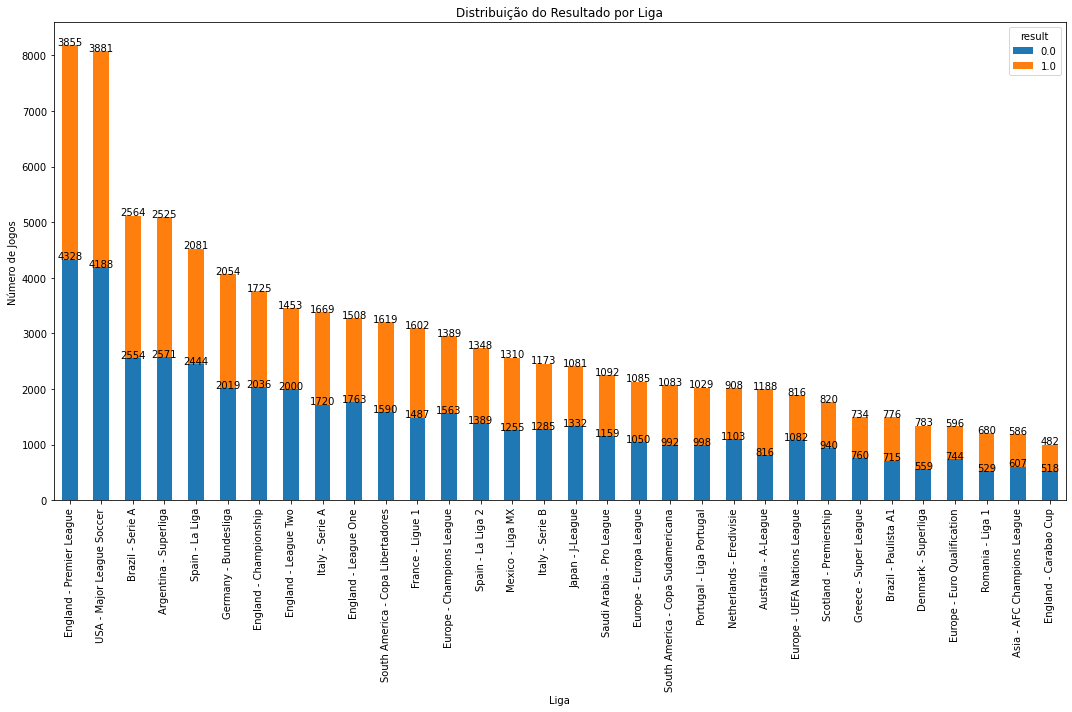

In [260]:
def filter_leagues(df, league_col, matches, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    # Contando o número de jogos por liga
    league_game_counts = df.groupby(league_col)[matches].nunique()

    # Filtrando as ligas com pelo menos 100 jogos
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index

    # Filtrando o dataframe para incluir apenas as ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]


    return filtered_data

def balance_data(df, result_col='result'):
    result_counts = df[result_col].value_counts()

    # Balanceando a coluna 'result' - escolhendo o menor número de instâncias entre 0 e 1
    min_count = result_counts.min()

    # Amostrando aleatoriamente linhas para cada valor de 'result'
    balanced_data = pd.concat([
        df[df[result_col] == 0].sample(min_count, random_state=42),
        df[df[result_col] == 1].sample(min_count, random_state=42)
    ])

    return balanced_data

# Aplicando as funções ao DataFrame original
print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nBalanceando dados...")
balanced_data = balance_data(df, 'result')
df = balanced_data
print("Dados balanceados:\n")
print(df['result'].value_counts())

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())
df = filtered_data

df.drop_duplicates(keep='last', inplace=True)
df.dropna(inplace=True)

league_distribution = df.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

# Iterando sobre as barras e adicionando anotações
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()


## Separação de Características, Transformação e Divisão de Dados

In [219]:
# df.to_csv('data_balanced.csv', index=False, encoding='utf-8')
df.shape

(93556, 24)

In [261]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


# Modelos

## H2O AutoML

### Conversão de Dados a Treinamento, Carregamento e Salvamento

In [267]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["C" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["C" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 hours 29 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_Pichau_muuj72
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.166 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (74872, 58)
y_train_h2o shape: (74872, 1)
X_test_h2o shape: (18719, 58)
y_test_h2o shape: (18719, 1)


In [268]:
# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='aucpr')
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

AutoML progress: |██
03:36:53.585: AutoML: XGBoost is not available; skipping it.

█████████████████████████████████████████████████████████████| (done) 100%
model_id                                                   aucpr       auc    logloss    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_2_20231125_33653     0.895179  0.90058    0.396375                0.190785  0.357934  0.128116
StackedEnsemble_BestOfFamily_1_AutoML_2_20231125_33653  0.889082  0.893539   0.409732                0.199604  0.364404  0.13279
DRF_1_AutoML_2_20231125_33653                           0.876436  0.878467   0.559036                0.218842  0.432363  0.186938
GBM_grid_1_AutoML_2_20231125_33653_model_3              0.864016  0.873451   0.500188                0.217829  0.403689  0.162965
GBM_grid_1_AutoML_2_20231125_33653_model_1              0.86045   0.871881   0.470829                0.220638  0.390381  0.152398
GBM_4_AutoML_2_20231125_33653                           0.83037

### Avaliação de métricas

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


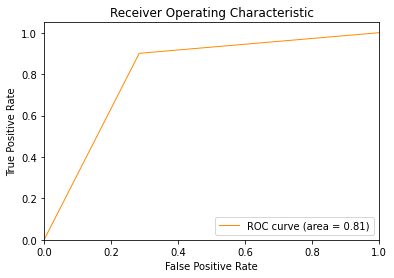

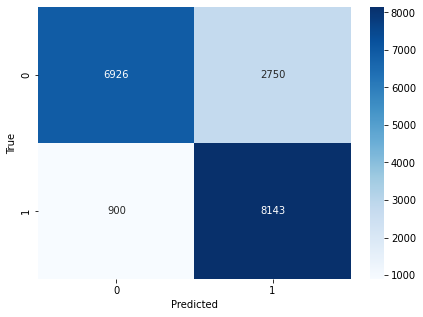

In [269]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
loaded_model = h2o.load_model(model_path)
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [270]:
from sklearn.metrics import classification_report

# Certifique-se de que y_test é um array ou lista
# Se y_test for um DataFrame ou Series, converta usando .tolist() ou .values
y_test_list = y_test.tolist() if hasattr(y_test, 'tolist') else y_test

# Gerando o relatório de classificação
report = classification_report(y_test_list, y_pred_round, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.88      0.72      0.79      9676
    Classe 1       0.75      0.90      0.82      9043

    accuracy                           0.81     18719
   macro avg       0.82      0.81      0.80     18719
weighted avg       0.82      0.81      0.80     18719



### Na prática

In [18]:
df.head(1699).tail(1)['result']

36841    0.0
Name: result, dtype: float64

In [271]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.63579,0.36421


In [ ]:
# h2o.export_file(frame=lb, path='lb.csv', force=True)

In [21]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


0.4927720095951262

### Importancia dos atributos

In [272]:
import shap
# função de previsão para o modelo H2O
def model_predict(data_as_array):
    h2o_df = h2o.H2OFrame(pd.DataFrame(data_as_array, columns=["C" + str(i) for i in range(data_as_array.shape[1])]))
    preds = loaded_model.predict(h2o_df)
    preds_df = preds.as_data_frame()
    # Assegurar que as previsões estejam no formato correto (array 2D com duas colunas)
    return preds_df.iloc[:, -2:].values


# Converter H2OFrame para DataFrame do pandas
X_train_pd = h2o.as_list(X_train_h2o)
X_test_pd = h2o.as_list(X_test_h2o)

# explainer usando KernelExplainer para um modelo H2O
explainer = shap.KernelExplainer(model_predict, X_train_pd.iloc[:50])

# Calcula os valores SHAP para um subconjunto do conjunto de teste
shap_values_h2o = explainer.shap_values(X_test_pd.iloc[:50])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


  0%|          | 0/50 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


  2%|▏         | 1/50 [00:41<33:45, 41.33s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


  4%|▍         | 2/50 [01:22<33:06, 41.39s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


  6%|▌         | 3/50 [02:04<32:27, 41.43s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


  8%|▊         | 4/50 [02:45<31:50, 41.53s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 10%|█         | 5/50 [03:27<31:07, 41.49s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 12%|█▏        | 6/50 [04:08<30:24, 41.46s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 14%|█▍        | 7/50 [04:52<30:17, 42.27s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 16%|█▌        | 8/50 [05:34<29:23, 41.99s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 18%|█▊        | 9/50 [06:15<28:36, 41.87s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 20%|██        | 10/50 [06:59<28:14, 42.36s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 22%|██▏       | 11/50 [07:40<27:21, 42.09s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 24%|██▍       | 12/50 [08:22<26:33, 41.94s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 26%|██▌       | 13/50 [09:04<25:50, 41.90s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 28%|██▊       | 14/50 [09:45<25:02, 41.74s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 30%|███       | 15/50 [10:29<24:41, 42.33s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 32%|███▏      | 16/50 [11:12<24:13, 42.75s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 34%|███▍      | 17/50 [11:55<23:28, 42.69s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 36%|███▌      | 18/50 [12:38<22:54, 42.95s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 38%|███▊      | 19/50 [13:20<21:57, 42.50s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 40%|████      | 20/50 [14:02<21:08, 42.28s/it]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


 40%|████      | 20/50 [14:43<22:04, 44.16s/it]


ValueError: cannot reshape array of size 214402 into shape (107200,2)

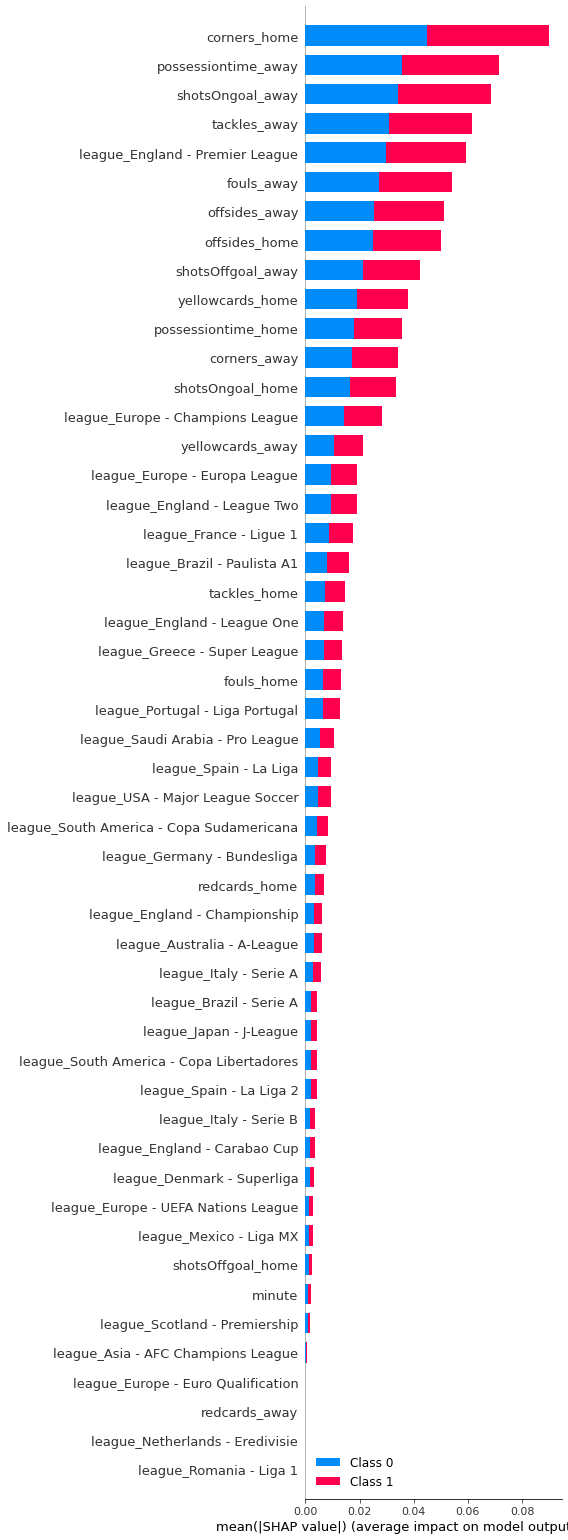

In [ ]:
# Obter os nomes das colunas numéricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Obter os nomes das colunas após a transformação
# Para as características numéricas, permanecem os mesmos
transformed_numeric_features = numeric_features

# como so tem uma caracteristica categorica:
categories = preprocessor.named_transformers_['cat'].categories_
transformed_categorical_features = [
    f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
]

# Combina os dois
all_transformed_features = transformed_numeric_features + transformed_categorical_features

shap.summary_plot(shap_values_h2o, features=X_test_pd.iloc[:50], feature_names=all_transformed_features, max_display=X_test_pd.iloc[:50].shape[1])

## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento e carregamento

Epoch 1/200
1872/1872 [==============================] - 6s 2ms/step - loss: 0.8557 - accuracy: 0.5070 - auc_1: 0.5095 - val_loss: 0.8101 - val_accuracy: 0.5288 - val_auc_1: 0.5421
Epoch 2/200
1872/1872 [==============================] - 3s 2ms/step - loss: 0.8060 - accuracy: 0.5101 - auc_1: 0.5151 - val_loss: 0.7834 - val_accuracy: 0.5368 - val_auc_1: 0.5498
Epoch 3/200
1872/1872 [==============================] - 3s 2ms/step - loss: 0.7765 - accuracy: 0.5145 - auc_1: 0.5217 - val_loss: 0.7617 - val_accuracy: 0.5402 - val_auc_1: 0.5529
Epoch 4/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7554 - accuracy: 0.5179 - auc_1: 0.5261 - val_loss: 0.7446 - val_accuracy: 0.5358 - val_auc_1: 0.5513
Epoch 5/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7389 - accuracy: 0.5246 - auc_1: 0.5357 - val_loss: 0.7314 - val_accuracy: 0.5392 - val_auc_1: 0.5581
Epoch 6/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7268 - accuracy:

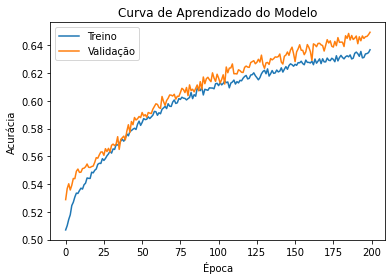

In [226]:
# import tensorflow as tf

# print("Iniciando a construção do modelo...")
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# # Compilando o modelo
# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# # Configurando o Early Stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=50)

# # Treinando o modelo
# print("Treinando o modelo...")
# history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# # Fazendo as predições
# print("Fazendo predições no conjunto de teste...")
# predictions = model.predict(X_test)
# predictions = np.where(predictions > 0.5, 1, 0)

# # Avaliando a acurácia do modelo
# train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
# test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
# print('Acurácia no conjunto de treinamento:', train_acc)
# print('Acurácia no conjunto de teste:', test_acc)

# # Plotando a curva de aprendizado
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Curva de Aprendizado do Modelo')
# plt.ylabel('Acurácia')
# plt.xlabel('Época')
# plt.legend(['Treino', 'Teste'], loc='upper left')
# plt.show()

# # Salvando o modelo
# print("Salvando o modelo treinado...")
# model.save('../models/model_redeht.h5')
# print("Modelo salvo como 'model_redeht.h5'")

# from tensorflow.keras.regularizers import l2
# l2
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
import tensorflow as tf

# Iniciando a construção do modelo...
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Adicionando Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Adicionando Dropout
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
optimizer = Adam(learning_rate=0.0001)  # Taxa de aprendizado reduzida
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Configurando o Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # Paciência reduzida

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=32,  # Epochs e batch size ajustados
                    validation_split=0.2,  # Usando parte dos dados de treino para validação
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht.h5')


Epoch 1/200
936/936 [==============================] - 3s 2ms/step - loss: 0.7144 - accuracy: 0.5297 - auc_2: 0.5408 - val_loss: 0.7033 - val_accuracy: 0.5533 - val_auc_2: 0.5787
Epoch 2/200
936/936 [==============================] - 2s 2ms/step - loss: 0.7024 - accuracy: 0.5485 - auc_2: 0.5710 - val_loss: 0.6962 - val_accuracy: 0.5644 - val_auc_2: 0.5916
Epoch 3/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6966 - accuracy: 0.5557 - auc_2: 0.5814 - val_loss: 0.6923 - val_accuracy: 0.5716 - val_auc_2: 0.6028
Epoch 4/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6912 - accuracy: 0.5650 - auc_2: 0.5944 - val_loss: 0.6861 - val_accuracy: 0.5751 - val_auc_2: 0.6063
Epoch 5/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6866 - accuracy: 0.5733 - auc_2: 0.6058 - val_loss: 0.6857 - val_accuracy: 0.5735 - val_auc_2: 0.6110
Epoch 6/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6822 - accuracy: 0.5796 - au

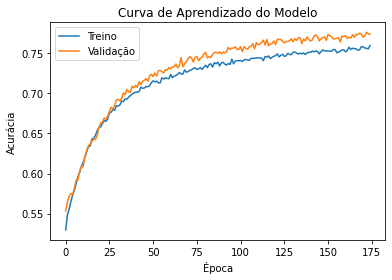

In [227]:
# Iniciando a construção do modelo com uma arquitetura mais complexa...
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.0001)))  # Mais neurônios
model.add(Dropout(0.3))  # Dropout reduzido
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))  # Mais neurônios
model.add(Dropout(0.3))  # Dropout reduzido
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo com uma taxa de aprendizado ajustada
optimizer = Adam(learning_rate=0.0005)  # Taxa de aprendizado ajustada
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Configurando o Early Stopping com uma paciência ajustada
early_stop = EarlyStopping(monitor='val_loss', patience=10)  # Menos paciência para que o modelo não treine demais

# Treinando o modelo com uma divisão de validação e tamanhos de batch ajustados
history = model.fit(X_train, y_train, epochs=200, batch_size=64,  # Tamanho de batch aumentado
                    validation_split=0.2,  # Continuando com a divisão de validação
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_updated.h5')

Epoch 1/300
936/936 [==============================] - 3s 2ms/step - loss: 0.7032 - accuracy: 0.5340 - auc_4: 0.5477 - val_loss: 0.6962 - val_accuracy: 0.5431 - val_auc_4: 0.5694
Epoch 2/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6933 - accuracy: 0.5543 - auc_4: 0.5797 - val_loss: 0.6896 - val_accuracy: 0.5627 - val_auc_4: 0.5927
Epoch 3/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6877 - accuracy: 0.5656 - auc_4: 0.5953 - val_loss: 0.6840 - val_accuracy: 0.5714 - val_auc_4: 0.6061
Epoch 4/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6821 - accuracy: 0.5777 - auc_4: 0.6114 - val_loss: 0.6785 - val_accuracy: 0.5769 - val_auc_4: 0.6178
Epoch 5/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6770 - accuracy: 0.5846 - auc_4: 0.6237 - val_loss: 0.6757 - val_accuracy: 0.5955 - val_auc_4: 0.6344
Epoch 6/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.5948 - au

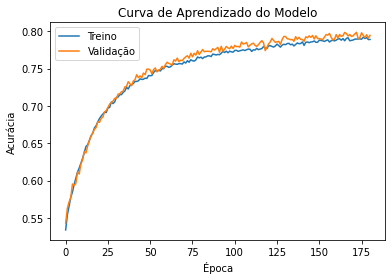

In [262]:
# Continuando com a arquitetura atual...
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Mantendo a taxa de aprendizado e o tamanho do batch do último ajuste
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Aumentando a paciência no EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15)  # Paciência aumentada para permitir mais treinamento

# Treinando o modelo com mais épocas
history = model.fit(X_train, y_train, epochs=300, batch_size=64,  # Aumento do número de épocas
                    validation_split=0.2,
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_final.h5')

### Importancia de atributos 

In [264]:
from keras.models import load_model
model = load_model('../models/model_redeht_final.h5')

import shap
# Criando o explainer
explainer = shap.DeepExplainer(model, X_train)
# Subconjunto do conjunto de teste para análise
X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# Calculando os valores SHAP
shap_values = explainer.shap_values(X_test_sample)
# Plotando um gráfico de resumo
# shap.summary_plot(shap_values, X_test_sample)

# Obter os nomes das colunas numéricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Obter os nomes das colunas após a transformação
# Para as características numéricas, permanecem os mesmos
transformed_numeric_features = numeric_features

# Como só tem uma característica categórica:
categories = preprocessor.named_transformers_['cat'].categories_
transformed_categorical_features = [
    f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
]

# Combina os dois
all_transformed_features = transformed_numeric_features + transformed_categorical_features

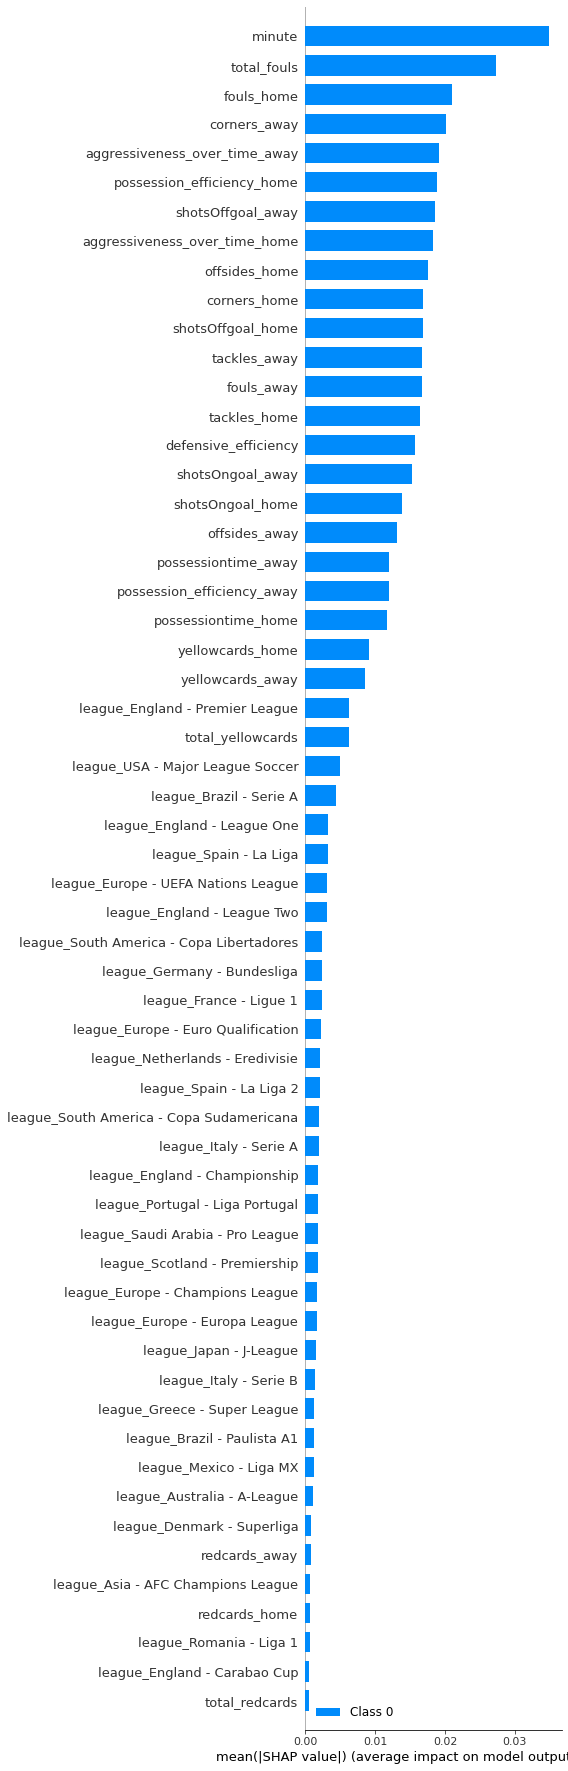

In [265]:
# Plotando um gráfico de resumo com nomes de features reais
shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])

### Avaliação de métricas 

In [266]:
from sklearn.metrics import classification_report
import numpy as np

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


585/585 [==============================] - 1s 848us/step
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.87      0.70      0.78      9676
    Classe 1       0.74      0.89      0.81      9043

    accuracy                           0.79     18719
   macro avg       0.80      0.80      0.79     18719
weighted avg       0.81      0.79      0.79     18719

